In [1]:
from model import interaction_model

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import glob
import argparse
import os
import seaborn as sns
import matplotlib
import statsmodels.api as sm

---

### Plot settings

In [2]:
plt.rcParams['figure.figsize'] = (10, 6)  
plt.rcParams['font.size'] = 18  
plt.rcParams['axes.titlesize'] = 20 
plt.rcParams['axes.labelsize'] = 18 
plt.rcParams['xtick.labelsize'] = 16 
plt.rcParams['ytick.labelsize'] = 16 
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20
matplotlib.rcParams['savefig.directory'] = 'img'

---

### Data loading and processing

In [3]:
def load_and_process_data(fp):
    """
    Load and process data from files matching the given file pattern,
    organise the data, and return it as a pandas DataFrame.

    Parameters:
        fp (str): File path pattern to match the files to be loaded.

    Returns:
        pd.DataFrame: A DataFrame containing the organised data.
    """
    # Get the list of files matching the pattern
    file_list = glob.glob(fp)

    # Initialize a list to store the data
    data = []

    # Process each file
    for file in file_list:
        # Load data from the file
        loaded_data = np.load(file, allow_pickle=True).item()

        # Extract results for each gamma
        gamma = loaded_data['gamma']
        all_psi = loaded_data['psi']
        all_infected = loaded_data['infected']
        all_aware = loaded_data['aware']
        mean_psi = loaded_data['mean_psi']
        mean_infected = loaded_data['mean_infected']
        mean_aware = loaded_data['mean_aware']

        # Add individual data to the list
        for psi, infected, aware in zip(all_psi, all_infected, all_aware):
            data.append({
                "gamma": gamma,
                "psi": psi,
                "aware": aware,
                "infected": infected
            })

        # Add mean values (optional)
        data.append({
            "gamma": gamma,
            "psi": mean_psi,
            "aware": mean_aware,
            "infected": mean_infected,
            "type": "mean"  # For distinction
        })

    # Convert the list to a DataFrame and return it
    return pd.DataFrame(data)

In [4]:
high_fp = "data/high_infection_rate/*.npy"
high_df = load_and_process_data(high_fp)
high_df_mean = high_df[high_df.get("type") == "mean"]

low_fp = "data/low_infection_rate/*.npy"
low_df = load_and_process_data(low_fp)
low_df_mean = low_df[low_df.get("type") == "mean"]

---

### Scatter plots

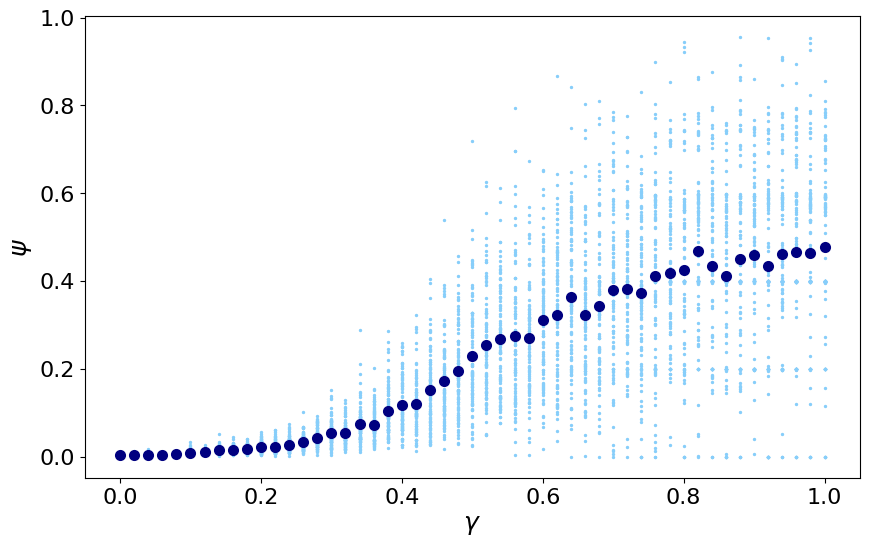

In [5]:
plt.scatter(high_df["gamma"], high_df["psi"], color="lightskyblue", s=2)
plt.scatter(high_df_mean["gamma"], high_df_mean["psi"], color="navy", linewidth=2, marker="o")
plt.xlabel("$\\gamma$")
plt.ylabel("$\\psi$")
plt.savefig("img/gamma_psi_scatter.png")
plt.show()

In [6]:
def my_scatter(df, x_variable, y_variable, x_label, y_label, output_path, x_log_scale=False, y_log_scale=False):
    """
    Create a scatter plot of `x_variable` vs `y_variable` with colors representing `gamma`,
    optionally applying logarithmic scales to axes.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data to plot.
        x_variable (str): Column name in `df` for the x-axis.
        y_variable (str): Column name in `df` for the y-axis.
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.
        output_path (str): Path to save the output plot (without extension).
        x_log_scale (bool): Whether to use logarithmic scale for the x-axis.
        y_log_scale (bool): Whether to use logarithmic scale for the y-axis.

    Returns:
        None
    """
    # Set the colormap
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=df["gamma"].min(), vmax=df["gamma"].max())

    # Log-transform variables for correlation if scales are logarithmic
    x_data = np.log10(df[x_variable]) if x_log_scale else df[x_variable]
    y_data = np.log10(df[y_variable]) if y_log_scale else df[y_variable]

    # Create the plot
    plt.figure(figsize=(10, 6))
    sc = plt.scatter(df[x_variable], df[y_variable] / 1000, c=df["gamma"], cmap=cmap, norm=norm, s=60)

    # Calculate and print the correlation coefficient
    correlation = x_data.corr(y_data)
    print(f"Correlation Coefficient of {x_variable} and {y_variable} (log-adjusted if applicable): {correlation:.3f}")

    # Apply log scales if specified
    if x_log_scale:
        plt.xscale('log')
    if y_log_scale:
        plt.yscale('log')

    # Add a colorbar
    cbar = plt.colorbar(sc)
    cbar.set_label(r'$\gamma$', fontsize=14)
    cbar.ax.tick_params(labelsize=14)

    # Set axis labels
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)

    # Add grid and adjust layout
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # Save the plot
    plt.savefig(output_path + ".png")
    plt.show()

#### High infection rate case ($\beta = 0.05, \mu = 0.01$)

Correlation Coefficient of psi and infected (log-adjusted if applicable): 0.761


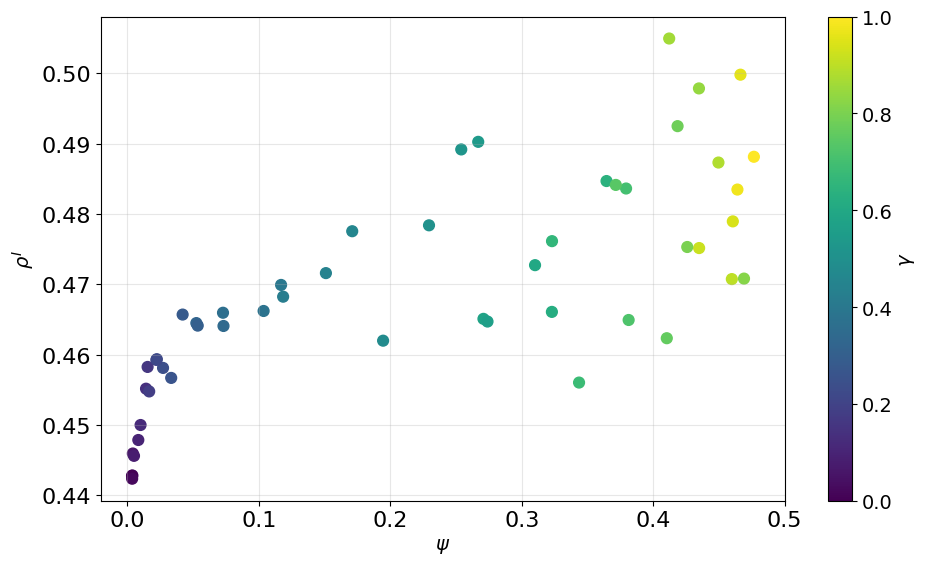

In [7]:
my_scatter(high_df_mean, "psi", "infected", r"$\psi$" , r"$\rho^I$", "img/high_infection_rate/high_psi_rho_I", x_log_scale=False)

Correlation Coefficient of psi and infected (log-adjusted if applicable): 0.816


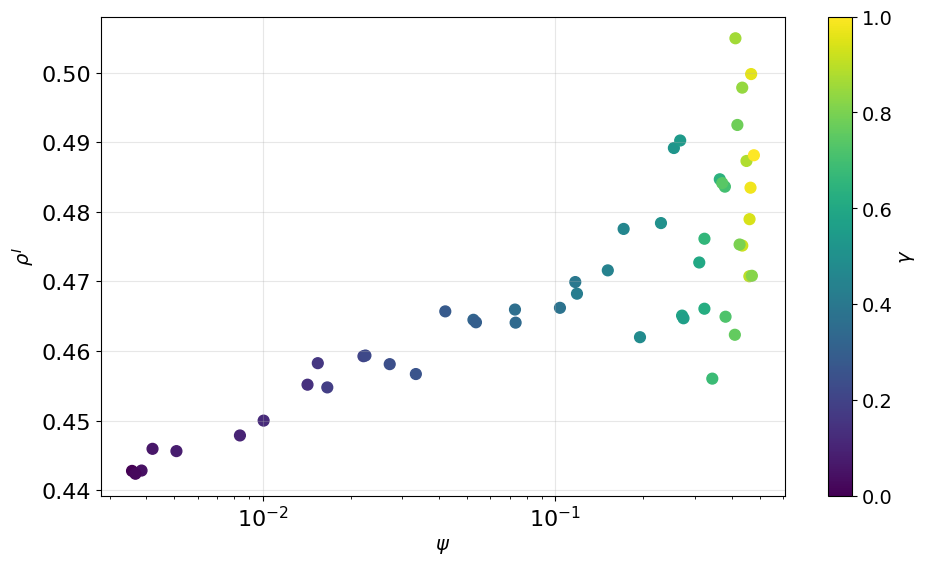

In [8]:
my_scatter(high_df_mean, "psi", "infected", r"$\psi$" , r"$\rho^I$", "img/high_infection_rate/high_log_psi_rho_I", x_log_scale=True)

Correlation Coefficient of psi and aware (log-adjusted if applicable): 0.343


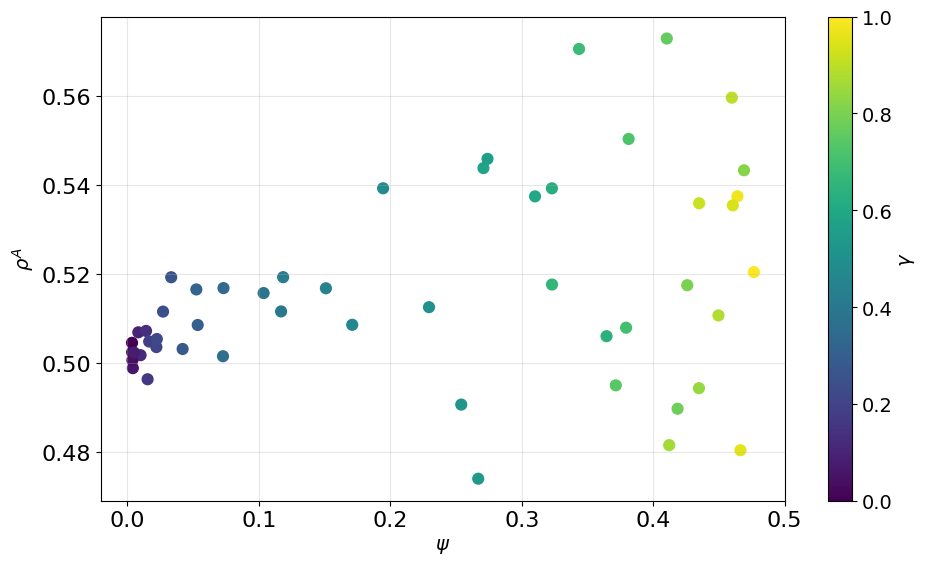

In [9]:
my_scatter(high_df_mean, "psi", "aware", r"$\psi$" , r"$\rho^A$", "img/high_infection_rate/high_psi_rho_A", x_log_scale=False)

Residual correlation between psi (after removing aware's effect) and infected: 0.885599545352629


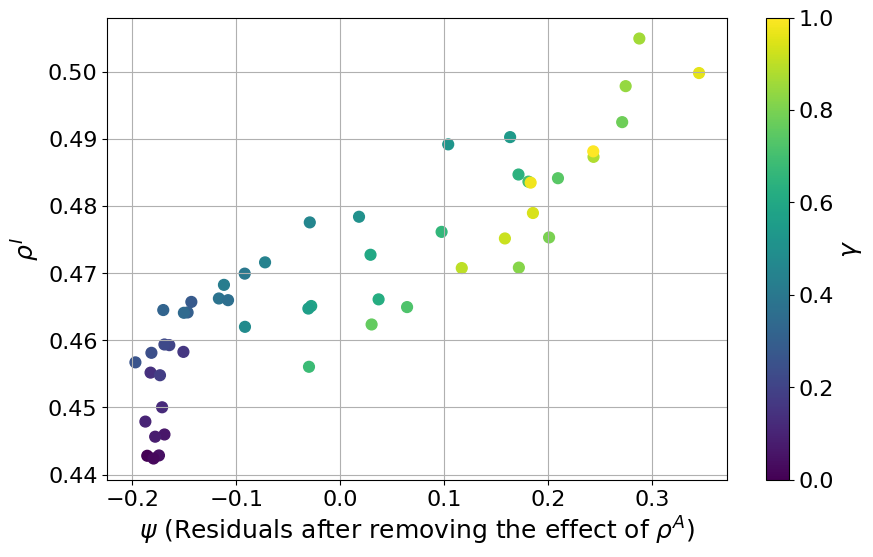

In [10]:
# Regression of high_df_mean["psi"] on high_df_mean["aware"]
high_X = sm.add_constant(high_df_mean["aware"]/1000)  # Add constant term
high_y = high_df_mean["psi"]
high_model = sm.OLS(high_y, high_X).fit()

# Get the residuals (the part of psi not explained by aware)
high_residuals_psi = high_model.resid

# Calculate the correlation of the residuals with high_df_mean["infected"]
correlation = high_residuals_psi.corr(high_df_mean["infected"]/1000)
print("Residual correlation between psi (after removing aware's effect) and infected:", correlation)

# plot
plt.figure(figsize=(10, 6))
high_scatter = plt.scatter(high_residuals_psi, high_df_mean["infected"]/1000, c=high_df_mean["gamma"], cmap='viridis', s=60)
# Add a color bar to the plot to indicate the gamma values
plt.colorbar(high_scatter, label=r"$\gamma$")
plt.xlabel(r"$\psi$ (Residuals after removing the effect of $\rho^A$)")
plt.ylabel(r"$\rho^I$")
plt.grid(True)
plt.savefig("img/high_infection_rate/high_psi_rho_I_residuals.png")
plt.show()

#### Low infection rate case ($\beta = 0.005, \mu = 0.1$)

Correlation Coefficient of psi and infected (log-adjusted if applicable): -0.671


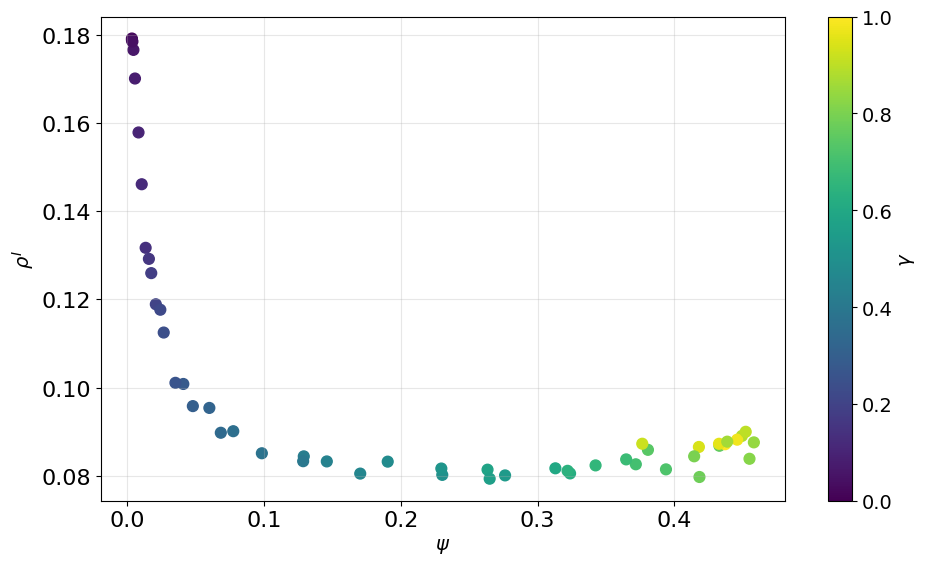

In [11]:
my_scatter(low_df_mean, "psi", "infected", r"$\psi$" , r"$\rho^I$", "img/low_infection_rate/low_psi_rho_I", x_log_scale=False)

Correlation Coefficient of psi and infected (log-adjusted if applicable): -0.923


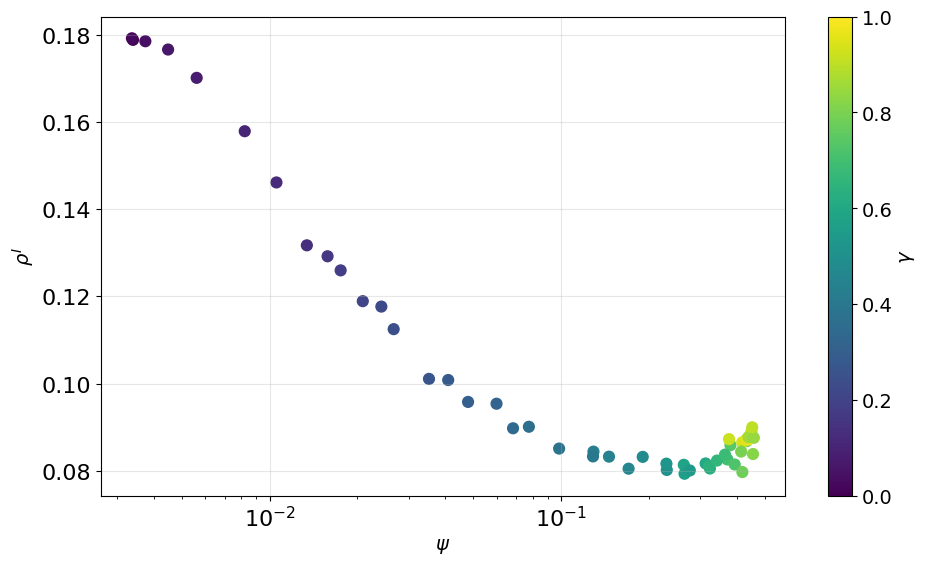

In [12]:
my_scatter(low_df_mean, "psi", "infected", r"$\psi$" , r"$\rho^I$", "img/low_infection_rate/low_log_psi_rho_I", x_log_scale=True)

Correlation Coefficient of psi and aware (log-adjusted if applicable): -0.963


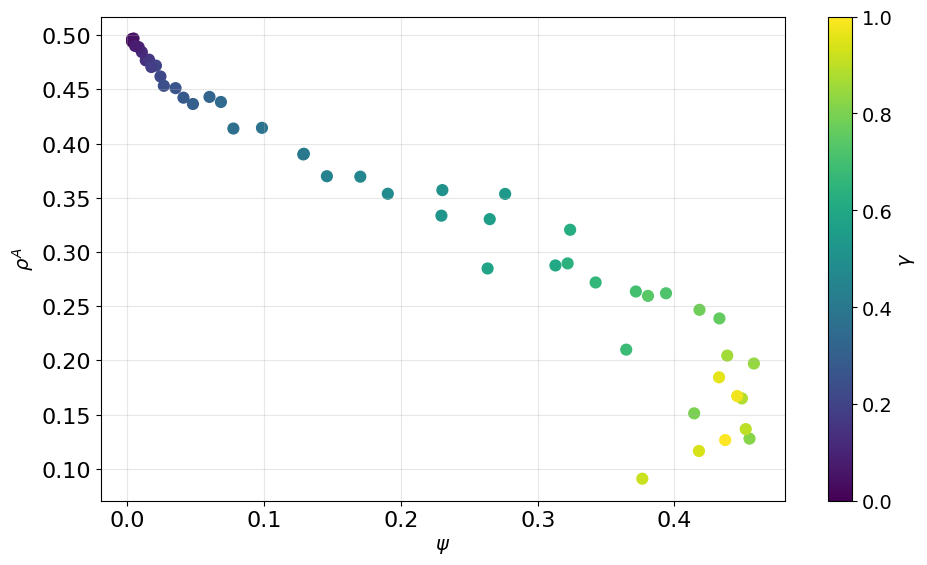

In [13]:
my_scatter(low_df_mean, "psi", "aware", r"$\psi$" , r"$\rho^A$", "img/low_infection_rate/low_log_psi_rho_A", x_log_scale=False)

Residual correlation between psi (after removing aware's effect) and infected: -0.16069510421084796


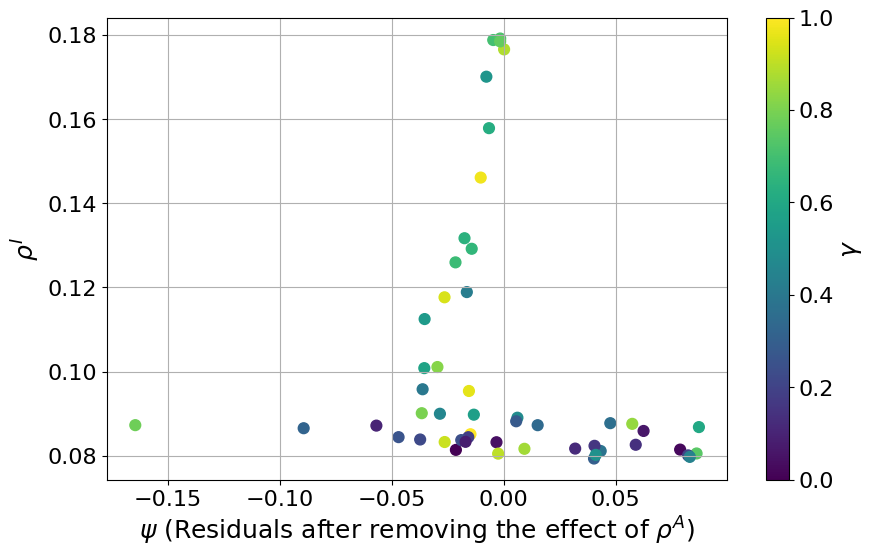

In [14]:
# Regression of low_df_mean["psi"] on low_df_mean["aware"]
low_X = sm.add_constant(low_df_mean["aware"]/1000)  # Add constant term
low_y = low_df_mean["psi"]
low_model = sm.OLS(low_y, low_X).fit()

# Get the residuals (the part of psi not explained by aware)
low_residuals_psi = low_model.resid

# Calculate the correlation of the residuals with high_df_mean["infected"]
low_correlation = low_residuals_psi.corr(low_df_mean["infected"]/1000)
print("Residual correlation between psi (after removing aware's effect) and infected:", low_correlation)

# plot
plt.figure(figsize=(10, 6))
low_scatter = plt.scatter(low_residuals_psi, low_df_mean["infected"]/1000, c=high_df_mean["gamma"], cmap='viridis', s=60)
# Add a color bar to the plot to indicate the gamma values
plt.colorbar(low_scatter, label=r"$\gamma$")
plt.xlabel(r"$\psi$ (Residuals after removing the effect of $\rho^A$)")
plt.ylabel(r"$\rho^I$")
plt.grid(True)
plt.savefig("img/low_infection_rate/low_psi_rho_I_residuals.png")
plt.show()

---

### Heatmap

In [15]:
heatmap_data = np.load("data/heatmap/heatmap_data.npy")

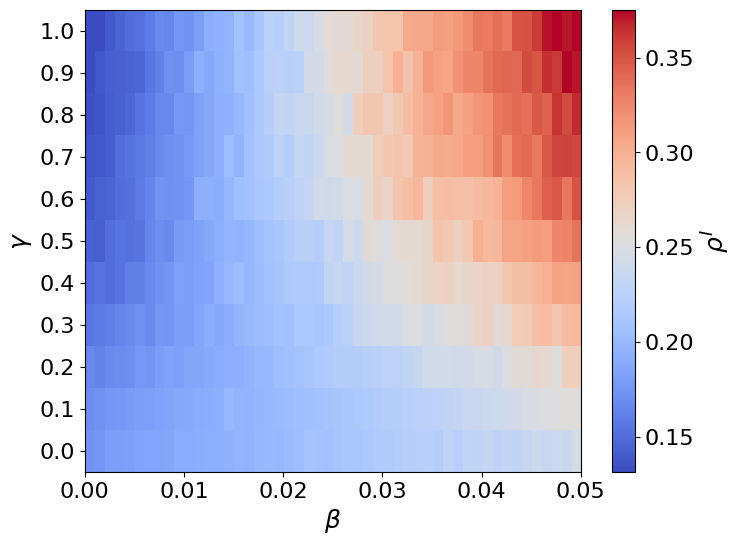

In [16]:
# Plotting the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data / 1000, cmap="coolwarm", origin="lower", aspect="auto")
plt.colorbar(label="$\\rho^I$")

# Adjusting the Y-axis ticks
yticks = range(0, 11)  # Current tick positions (0, 1, ..., 10)
yticks_labels = [f"{y / 10:.1f}" for y in yticks]  # Convert to labels divided by 10
plt.yticks(ticks=yticks, labels=yticks_labels)

plt.ylabel(r"$\gamma$")
plt.xlabel(r"$\beta$")

# Adjusting the X-axis
xticks = [0, 0.01, 0.02, 0.03, 0.04, 0.05]  # Original x-axis ticks
xticks_shifted = [x - 0.0005 for x in xticks]  # Shift each value slightly to the left
plt.xticks(
    ticks=[item * 1000 for item in xticks_shifted],
    labels=[f"{x:.2f}" for x in xticks]
)


plt.savefig(os.path.join("img/heatmap", "heatmap.png"))
plt.show()